In [1]:
import zipfile

In [2]:
import numpy as np
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
%matplotlib inline

In [5]:
pd.options.display.max_columns = 50

# Read data

In [6]:
with zipfile.ZipFile("data/train.csv.zip") as z:
    names = z.namelist()
    print(f"names: {names}")
    with z.open(names[0]) as f:
        pd_train = pd.read_csv(f, index_col=0)
        
with zipfile.ZipFile("data/test.csv.zip") as z:
    names = z.namelist()
    print(f"names: {names}")
    with z.open(names[0]) as f:
        pd_test = pd.read_csv(f, index_col=0)
        
pd_sample = pd.read_csv("data/sample_submission.csv")

names: ['train.csv']
names: ['test.csv']


In [7]:
pd_train.head(2)

,Id_Пациента,Возраст,Диагноз,Жалобы,Источник_рекламы,Клиника,Код_диагноза,Пол,Услуга
0,115819,54,Гипертензивная болезнь сердца [гипертоническая...,"на повышение ад утром до 140/90 мм.рт.ст., пер...",Другое,5,I11,2,"Прием врача-кардиолога повторный, амбулаторный"
1,399973,32,Доброкачественное новообразование молочной железы,На наличие опухоли в левой молочной железе,Другое,3,D24,2,"Прием врача-онколога (маммолога), повторный, а..."


In [8]:
pd_test.head(2)

,Id_Пациента,Возраст,Жалобы,Источник_рекламы,Клиника,Пол,Услуга
0,598841,43,на момент осмотра не предъявляет,Рекомендации знакомых,5,2,"Прием врача-акушера-гинеколога повторный, амбу..."
1,596613,37,"На слабость, головную боль, на расфокусировку ...",Зарегистрировался на сайте,3,1,"Прием врача-кардиолога повторный, амбулаторный"


In [9]:
pd_sample.head(2)

,index,Код_диагноза
0,0,J06.9
1,1,J06.9


In [10]:
pd_train.shape, pd_test.shape, pd_sample.shape

((49619, 9), (12021, 7), (12021, 2))

# Target

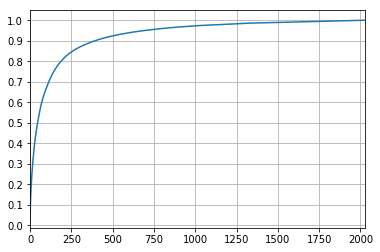

In [11]:
pd_train["Код_диагноза"].value_counts(normalize=True).cumsum().reset_index(drop=True) \
    .plot(grid=True, yticks=np.arange(0, 1.01, 0.1))

In [12]:
target_dict = pd_train["Код_диагноза"].value_counts().reset_index()["index"]
target_dict = target_dict.reset_index().set_index("index")
target_dict.iloc[1200:] = -1
target_dict_code2ix = target_dict['level_0'].to_dict()
target_dict_ix2code = {v: k for k, v in target_dict_code2ix.items() if v >= 0}

In [13]:
pd_train["y"] = pd_train["Код_диагноза"].map(target_dict_code2ix)

In [14]:
X = pd_train.loc[pd_train["y"].ge(0), ["Id_Пациента", "Возраст", "Жалобы", "Источник_рекламы", "Клиника", "Пол", "Услуга"]].copy()
y = pd_train.loc[pd_train["y"].ge(0), "y"].values

In [15]:
X.shape, y.shape

((48681, 7), (48681,))

In [16]:
from sklearn.model_selection import train_test_split
i_train, i_test = train_test_split(np.arange(y.shape[0]), test_size=0.3, stratify=y)

# Model

In [17]:
import sklearn
sklearn.__version__

'0.20.2'

In [18]:
from sklearn.model_selection import StratifiedKFold
from tqdm import tqdm_notebook

class StratifiedKFoldTqdm(StratifiedKFold):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
    
    def split(self, X, y, groups=None):
        return tqdm_notebook(super().split(X, y, None), total=self.n_splits)    
        
cv_skf = StratifiedKFoldTqdm(n_splits=5, random_state=42)

In [19]:
from sklearn.model_selection import cross_val_score

# Features

In [20]:
from sklearn.base import BaseEstimator, TransformerMixin

In [21]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, col_name):
        self.col_name = col_name
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.col_name].values

## MorphAnalyzer

In [22]:
from pymorphy2 import MorphAnalyzer

In [23]:
morph = MorphAnalyzer()

In [24]:
morph.parse("раму")

[Parse(word='раму', tag=OpencorporaTag('NOUN,inan,masc,Geox sing,datv'), normal_form='рам', score=0.5, methods_stack=((<DictionaryAnalyzer>, 'раму', 32, 2),)),
 Parse(word='раму', tag=OpencorporaTag('NOUN,inan,femn sing,accs'), normal_form='рама', score=0.5, methods_stack=((<DictionaryAnalyzer>, 'раму', 55, 3),))]

In [25]:
import re

In [26]:
class Normalizer(BaseEstimator, TransformerMixin):
    _cache = {}
    
    @staticmethod
    def _process(line):
        def norm(word):
            if word in Normalizer._cache:
                return Normalizer._cache[word]
            
            n = morph.parse(word)[0].normal_form
            Normalizer._cache[word] = n
            
            return n
        
        return " ".join([norm(word) for word in re.findall(r"\w+", line.lower())])
    
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.array([self._process(line) for line in X])

In [27]:
Normalizer().fit_transform(["Мама мыла- раму", "Папа чинил сапоги"])

array(['мама мыло рам', 'папа чинить сапог'], dtype='<U17')

## Услуга

In [28]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [29]:
pipe_service = Pipeline([
    ('select', ColumnSelector("Услуга")),
    ('norm', Normalizer()),
    ('tfidf', TfidfVectorizer()),
])

In [30]:
%%time
# pipe_service.set_params(tfidf__token_pattern=r"\b\w{,5}")
X_service = pipe_service.fit_transform(X)

Wall time: 717 ms


In [31]:
X_service.shape

(48681, 243)

In [32]:
pipe_service.named_steps["tfidf"].vocabulary_

{'001': 0,
 '15': 1,
 '18': 2,
 '28': 3,
 'air': 4,
 'flow': 5,
 'акушер': 6,
 'акция': 7,
 'аллерголог': 8,
 'амбулаторный': 9,
 'анатомический': 10,
 'ангиохирург': 11,
 'андролог': 12,
 'анестезия': 13,
 'апп': 14,
 'аппарат': 15,
 'аппликационный': 16,
 'бассейн': 17,
 'без': 18,
 'беременный': 19,
 'бесплатный': 20,
 'бесплый': 21,
 'бинокулярный': 22,
 'биомикроскопия': 23,
 'блокада': 24,
 'более': 25,
 'больший': 26,
 'бца': 27,
 'ваш': 28,
 'ведущий': 29,
 'весь': 30,
 'водянка': 31,
 'волновой': 32,
 'восстановление': 33,
 'врач': 34,
 'врачебный': 35,
 'временной': 36,
 'выдача': 37,
 'выписка': 38,
 'гастроэнтеролог': 39,
 'гастроэнтерологический': 40,
 'гибдд': 41,
 'гинеколог': 42,
 'гипсовый': 43,
 'главный': 44,
 'глаз': 45,
 'глазной': 46,
 'гнойный': 47,
 'гомеопатический': 48,
 'гомеосиниатрия': 49,
 'групон': 50,
 'день': 51,
 'дерматовенеролог': 52,
 'детский': 53,
 'диагноз': 54,
 'диагностический': 55,
 'диаметр': 56,
 'динамический': 57,
 'для': 58,
 'дневник': 

## Жалоба

In [33]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [34]:
pipe_symptom = Pipeline([
    ('select', ColumnSelector("Жалобы")),
    ('norm', Normalizer()),
    ('tfidf', TfidfVectorizer(min_df=4, max_df=0.6, max_features=10000)),
])

In [35]:
%%time
# pipe_service.set_params(tfidf__token_pattern=r"\b\w{,5}")
X_symptom = pipe_symptom.fit_transform(X)

Wall time: 3.44 s


In [36]:
X_symptom.shape

(48681, 2219)

In [37]:
X_symptom

<48681x2219 sparse matrix of type '<class 'numpy.float64'>'
	with 333416 stored elements in Compressed Sparse Row format>

In [38]:
pipe_symptom.named_steps["tfidf"].vocabulary_

{'повышение': 1348,
 'ада': 106,
 'утром': 2055,
 'до': 467,
 '140': 23,
 '90': 96,
 'мм': 886,
 'рт': 1679,
 'ст': 1848,
 'периодич': 1292,
 'головокружение': 377,
 'наличие': 951,
 'опухоль': 1155,
 'левый': 764,
 'молочный': 894,
 'железо': 510,
 'активный': 112,
 'жалоба': 499,
 'нет': 1033,
 'сохраняться': 1821,
 'боль': 187,
 'спина': 1830,
 'поясница': 1471,
 'скованность': 1760,
 'она': 1136,
 'дискомфорт': 445,
 'горло': 386,
 'слабый': 1770,
 'першение': 1303,
 'слабость': 1768,
 'палец': 1235,
 'правый': 1477,
 'кисть': 661,
 'не': 983,
 'измениться': 596,
 'момент': 895,
 'первое': 1260,
 'приём': 1530,
 'по': 1334,
 'цикл': 2125,
 'паховый': 1254,
 'подвздошный': 1356,
 'область': 1093,
 'фон': 2090,
 'лечение': 772,
 'самочувствие': 1691,
 'улучшение': 2018,
 'болевой': 177,
 'диспептический': 450,
 'синдром': 1748,
 'выразить': 320,
 'аппетит': 132,
 'норма': 1066,
 'переносить': 1274,
 'хорошо': 2111,
 'отмечаться': 1203,
 'положительный': 1417,
 'клинико': 668,
 'эндос

## Клиника

In [39]:
X["Клиника"].value_counts()

3     34456
6      5526
5      5408
2      3130
15      159
19        2
Name: Клиника, dtype: int64

In [40]:
from sklearn.preprocessing import OneHotEncoder

In [41]:
pipe_clinic = Pipeline([
    ('select', ColumnSelector(["Клиника"])),
    ('ohe', OneHotEncoder(sparse=False, categories='auto', handle_unknown="ignore")),
])

In [42]:
X_clinic = pipe_clinic.fit_transform(X)

In [43]:
X_clinic.shape

(48681, 6)

In [44]:
X_clinic

array([[0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       ...,
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.]])

## Пол

In [45]:
X["Пол"].value_counts()

2    33751
1    14930
Name: Пол, dtype: int64

In [46]:
from sklearn.preprocessing import OneHotEncoder

In [47]:
pipe_sex = Pipeline([
    ('select', ColumnSelector(["Пол"])),
    ('ohe', OneHotEncoder(sparse=False, categories='auto', handle_unknown="ignore")),
])

In [48]:
X_sex = pipe_sex.fit_transform(X)

In [49]:
X_sex.shape

(48681, 2)

In [50]:
X_sex

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [0., 1.]])

## Возраст

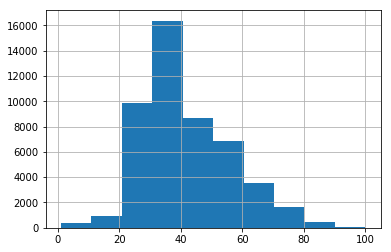

In [51]:
X["Возраст"].clip(0, 100).hist()

In [52]:
class ClipTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.clip(X, 0, 100)

In [53]:
from sklearn.preprocessing import MinMaxScaler

In [54]:
pipe_age = Pipeline([
    ('select', ColumnSelector(["Возраст"])),
    ('clip', ClipTransformer()),
    ('norm', MinMaxScaler()),
])

In [55]:
X_age = pipe_age.fit_transform(X)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [56]:
X_age.shape

(48681, 1)

In [57]:
X_age

array([[0.53535354],
       [0.31313131],
       [0.71717172],
       ...,
       [0.67676768],
       [0.29292929],
       [0.24242424]])

## Источник_рекламы

In [58]:
X["Источник_рекламы"].value_counts()

Другое                                29036
Интернет                               8582
Рекомендации знакомых                  7054
Зарегистрировался на сайте             1262
Живет-работает рядом                    844
Страховая                               422
Щиты,уличная реклама                    389
Рекомендации к доктору                  317
Кутузовский                             156
Гефест                                  117
Врач Бегма Андрей Николаевич             49
Листовки                                 33
Кунцево                                  30
не назвала                               23
дельта                                   23
ООО Дельта                               21
ДМС                                      21
Врач Суван-оол Марина Анатольевна        19
Уклеина Наталья Григорьевна              15
Сайт ИП Веревошников                     14
МедЭлит                                  13
Радио                                    13
Врач Чабан Ольга Васильевна     

In [59]:
from sklearn.preprocessing import OneHotEncoder

In [60]:
pipe_adv = Pipeline([
    ('select', ColumnSelector(["Источник_рекламы"])),
    ('ohe', OneHotEncoder(sparse=False, handle_unknown="ignore")),
])

In [61]:
X_adv = pipe_adv.fit_transform(X)

In [62]:
X_adv

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [63]:
X_adv.shape

(48681, 114)

# NN

In [64]:
import keras
import keras.backend as K
from keras import layers
from keras import Model

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [65]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [66]:
def get_model():
    i_service = layers.Input(shape=(X_service.shape[1],), name="service")
    l_service = layers.Dense(32, activation='relu')(i_service)

    i_clinic = layers.Input(shape=(X_clinic.shape[1],), name="clinic")
    l_clinic = layers.Dense(4, activation="relu")(i_clinic)

    i_adv = layers.Input(shape=(X_adv.shape[1],), name="adv")
    l_adv = layers.Dense(32, activation="relu")(i_adv)

    i_sex = layers.Input(shape=(X_sex.shape[1],), name="sex")
    l_sex = layers.Dense(4, activation="relu")(i_sex)

    i_age = layers.Input(shape=(X_age.shape[1],), name="age")
    l_age = layers.Dense(16, activation="relu")(i_age)

    i_symptom = layers.Input(shape=(X_symptom.shape[1],), name="symptom")
    l_symptom = layers.Dense(128, activation="relu")(i_symptom)

    h_merge = layers.concatenate([l_service, l_clinic, l_adv, l_sex, l_age])
    h_merge = layers.Dropout(0.2)(h_merge)
    h_merge = layers.Dense(128, activation="relu")(h_merge)

    h_merge2 = layers.concatenate([h_merge, l_symptom])
    h_merge2 = layers.Dropout(0.1)(h_merge2)
    h_merge2 = layers.Dense(512, activation="relu")(h_merge2)
    h_merge2 = layers.Dropout(0.1)(h_merge2)

    o_diagnosis = layers.Dense(1200, activation="softmax")(h_merge2)

    model = Model(inputs=[i_service, i_clinic, i_adv, i_sex, i_age, i_symptom], outputs=[o_diagnosis])
    
    model.compile(optimizer=keras.optimizers.adam(lr=0.0005, decay=0.0001),
              metrics=["categorical_accuracy"], loss="categorical_crossentropy")
    
    return model

In [67]:
model = get_model()

In [68]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
service (InputLayer)            (None, 243)          0                                            
__________________________________________________________________________________________________
clinic (InputLayer)             (None, 6)            0                                            
__________________________________________________________________________________________________
adv (InputLayer)                (None, 114)          0                                            
__________________________________________________________________________________________________
sex (InputLayer)                (None, 2)            0                                            
__________________________________________________________________________________________________
age (Input

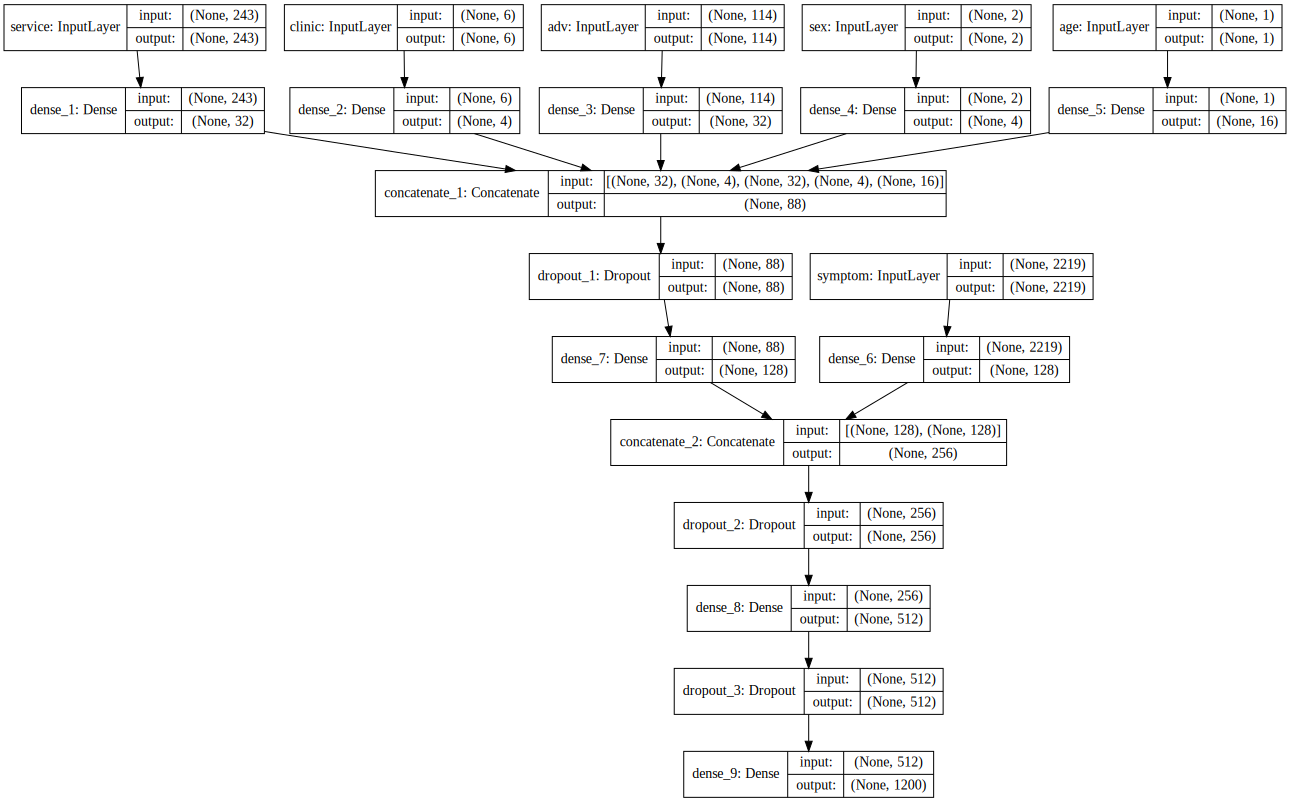

In [69]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [70]:
X_input = [X_service, X_clinic, X_adv, X_sex, X_age, X_symptom]

X_train = [m[i_train] for m in X_input]
X_test = [m[i_test] for m in X_input]

y_train = [keras.utils.to_categorical(y)[i_train]]
y_test = [keras.utils.to_categorical(y)[i_test]]

In [71]:
history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=2, validation_data=(X_test, y_test))

Train on 34076 samples, validate on 14605 samples
Epoch 1/50
 - 20s - loss: 5.1166 - categorical_accuracy: 0.1427 - val_loss: 3.9287 - val_categorical_accuracy: 0.2459
Epoch 2/50
 - 18s - loss: 3.5925 - categorical_accuracy: 0.2598 - val_loss: 3.2782 - val_categorical_accuracy: 0.2872
Epoch 3/50
 - 19s - loss: 3.1600 - categorical_accuracy: 0.2907 - val_loss: 3.0267 - val_categorical_accuracy: 0.3158
Epoch 4/50
 - 18s - loss: 2.9274 - categorical_accuracy: 0.3129 - val_loss: 2.8844 - val_categorical_accuracy: 0.3283
Epoch 5/50
 - 18s - loss: 2.7690 - categorical_accuracy: 0.3305 - val_loss: 2.7889 - val_categorical_accuracy: 0.3408
Epoch 6/50
 - 17s - loss: 2.6536 - categorical_accuracy: 0.3473 - val_loss: 2.7195 - val_categorical_accuracy: 0.3469
Epoch 7/50
 - 20s - loss: 2.5499 - categorical_accuracy: 0.3594 - val_loss: 2.6805 - val_categorical_accuracy: 0.3578
Epoch 8/50
 - 21s - loss: 2.4724 - categorical_accuracy: 0.3669 - val_loss: 2.6452 - val_categorical_accuracy: 0.3591
Epoch 

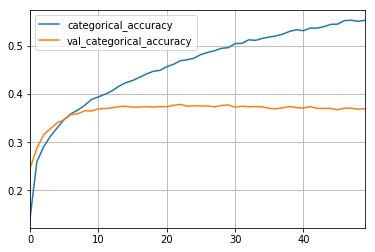

In [72]:
pd.DataFrame(history.history)[["categorical_accuracy", "val_categorical_accuracy"]] \
    .plot(grid=True)

# Submit

In [76]:
X_test_inp = [
    pipe_service.transform(pd_test), 
    pipe_clinic.transform(pd_test), 
    pipe_adv.transform(pd_test),
    pipe_sex.transform(pd_test),
    pipe_age.transform(pd_test),
    pipe_symptom.transform(pd_test),
]

In [80]:
model = get_model()

In [81]:
model.fit(X_input, keras.utils.to_categorical(y), batch_size=128, epochs=20, verbose=2)

Epoch 1/20
 - 23s - loss: 4.7658 - categorical_accuracy: 0.1691
Epoch 2/20
 - 25s - loss: 3.3033 - categorical_accuracy: 0.2773
Epoch 3/20
 - 24s - loss: 2.9629 - categorical_accuracy: 0.3083
Epoch 4/20
 - 26s - loss: 2.7647 - categorical_accuracy: 0.3321
Epoch 5/20
 - 25s - loss: 2.6314 - categorical_accuracy: 0.3488
Epoch 6/20
 - 24s - loss: 2.5324 - categorical_accuracy: 0.3611
Epoch 7/20
 - 22s - loss: 2.4452 - categorical_accuracy: 0.3712
Epoch 8/20
 - 22s - loss: 2.3801 - categorical_accuracy: 0.3807
Epoch 9/20
 - 22s - loss: 2.3238 - categorical_accuracy: 0.3886
Epoch 10/20
 - 22s - loss: 2.2676 - categorical_accuracy: 0.3967
Epoch 11/20
 - 22s - loss: 2.2289 - categorical_accuracy: 0.4009
Epoch 12/20
 - 22s - loss: 2.1873 - categorical_accuracy: 0.4083
Epoch 13/20
 - 22s - loss: 2.1509 - categorical_accuracy: 0.4142
Epoch 14/20
 - 22s - loss: 2.1190 - categorical_accuracy: 0.4201
Epoch 15/20
 - 23s - loss: 2.0842 - categorical_accuracy: 0.4268
Epoch 16/20
 - 23s - loss: 2.0555 

In [82]:
y_predict = model.predict(X_test_inp, batch_size=128)

In [83]:
pd_submit = pd.DataFrame({"index": pd_test.index})
pd_submit["y_predict"] = y_predict.argmax(axis=1)
pd_submit["Код_диагноза"] = pd_submit["y_predict"].map(target_dict_ix2code).fillna(target_dict_ix2code[0])

In [84]:
pd_submit[["index", "Код_диагноза"]].to_csv("submit_a01_1200.csv", index=None)